### Feature Engineering of the locations with data from ESRI - Demographics

Importing the data and shapefile

In [78]:
#CSV datasets of interest

import pandas as pd

train =pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.shape

(1460, 81)

<Item title:"AMES" type:Feature Layer Collection owner:nacho.moreno_JLLesp>
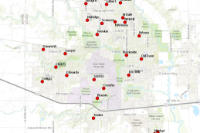

In [79]:
#Shapefile of interest we will enrich

#We will enrich the dataset

from arcgis.gis import GIS
from IPython.display import display
from arcgis.geoenrichment import *

gis = GIS("LINK", "PWD", "USER")

#We search for the layer

search_results = gis.content.search('title:AMES', 'Feature Layer')

AMES_neighborhoods = search_results[1]

AMES_neighborhoods



Create a simple map to visualize the data

In [81]:
AMES_map = gis.map(location =[42.019676, -93.624323], zoomlevel = 11)
AMES_map.basemap = 'streets-vector'
AMES_map.add_layer(AMES_neighborhoods)

AMES_map

MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oceans', 'osm', 'satellite', 'streets', 'streets-navigation-vector', 'streets-night-vector', 'streets-relief-vector', 'streets-vector', 'terrain', 'topo', 'topo-vector'], center=[42.019676, -93.624323], zoom=11)

We investigate which datasets we will be getting

In [ ]:
usa = Country.get('US')
usa.properties.datasets

datasets_esri = usa.data_collections

#These are the datasets we will be using

datasets_esri.loc['populationtotals']['analysisVariable'].unique()
datasets_esri.loc['lifemodegroupsNEW']['analysisVariable'].unique()
datasets_esri.loc['5yearincrements']['analysisVariable'].unique()
datasets_esri.loc['householdincome']['analysisVariable'].unique()
datasets_esri.loc['businesses']['analysisVariable'].unique()

We finally enrich the data

In [82]:
from arcgis.features import enrich_data
from arcgis.features import FeatureLayerCollection

data_collections = ['populationtotals','lifemodegroupsNEW','5yearincrements','householdincome','businesses']

analysis_variables= ['S12_BUS', 'S16_BUS', 'S24_BUS','MEDHINC_CY','AVGHINC_CY','PCI_CY','MEDAGE_CY','TLIFECODE','TLIFENAME','TOTPOP_CY']

AMES_enriched = enrich_data.enrich_layer(AMES_neighborhoods, buffer_type='StraightLine', distance=1 ,units='Kilometers', 
                                         data_collections= data_collections, analysis_variables = analysis_variables)

#How to transform a feature collection to a df, first we 'query' teh feature collection adn a 
#Featureset is returned, then we use the df method to transform to a pd dataframe 

#Documentation here https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#featurecollection and
# here: https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#featureset

AMES_enriched_df = AMES_enriched.query().df

In [83]:

#Lets change the name of the columns and clean the data
AMES_enriched_df = AMES_enriched_df.drop(['HasData', 'ID', 'ID_1', 'OBJECTID', 'ENRICH_FID', 'aggregationMethod', 'areaType', 'bufferUnits', 'sourceCountry', 'SHAPE' ], axis=1)
AMES_enriched_df = AMES_enriched_df.rename(index=str, columns={"AVGHINC_CY": "Average Household Income", 
                                                               "MEDAGE_CY": "Median Age",
                                                               "MEDHINC_CY": "Median Household Income",
                                                               "PCI_CY": "Per Capita Income",
                                                               "S12_BUS": "Food Stores (SIC54)",
                                                               "S16_BUS": "Eating & Drinking (SIC58)",
                                                               "S24_BUS": "Hotel/Lodging (SIC70)",
                                                               "TLIFECODE": "Dominant Tapestry LifeMode Group Code",
                                                               "TLIFENAME": "Dominant Tapestry LifeMode Group Name",
                                                               "TOTPOP_CY": "Total Population",
                                                               "bufferRadii": "Buffer Distance",
                                                               "bufferUnitsAlias": "Buffer Units" })

#Just to check we have the right data and save it ot a new dataframe and CSV so we dont need to run everytime
AMES_enriched_df.head(5)

,Average Household Income,Median Age,Median Household Income,Neighborhood,Per Capita Income,Food Stores (SIC54),Eating & Drinking (SIC58),Hotel/Lodging (SIC70),Dominant Tapestry LifeMode Group Code,Dominant Tapestry LifeMode Group Name,Total Population,Buffer Distance,Buffer Units
0,107120,45.0,73234,Timber,54059,1,1,1,5,GenXurban,1841,1,Kilometers
1,77663,28.3,53564,Veenker,34486,0,4,0,2,Upscale Avenues,3923,1,Kilometers
2,98860,40.0,75050,StoneBr,42476,2,5,0,4,Family Landscapes,3323,1,Kilometers
3,94082,34.4,81763,Somerst,39850,0,4,0,2,Upscale Avenues,4959,1,Kilometers
4,74934,29.7,58617,Sawyer,31749,0,1,0,5,GenXurban,3693,1,Kilometers


In [85]:
#Lets save the data in a CSV
AMES_enriched_df.to_csv('Neighborhoods_enriched.csv')

Last step is merge this data with our original data and save it to the original CSV

In [86]:
#Merge data and export to our original file for train and test
train_enriched = train.merge(AMES_enriched_df, on='Neighborhood')
train_enriched.to_csv('train_enriched.csv')


test_enriched = test.merge(AMES_enriched_df, on='Neighborhood')
test_enriched.to_csv('test_enriched.csv')